In [1]:
import sys
sys.path.append('../')
import potentials


In [2]:
import numpy as np
import cv2
from sksparse.cholmod import cholesky
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import pandas as pd
from itertools import product as prod
import proplot as pplt
from scipy.special import expit
from tqdm import tqdm
import itertools as it
import scipy
from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys
import networkx as nx

nr, nc = 128, 256
ksize = 13

np.random.seed(110104)
plt.rc("text", usetex=True)

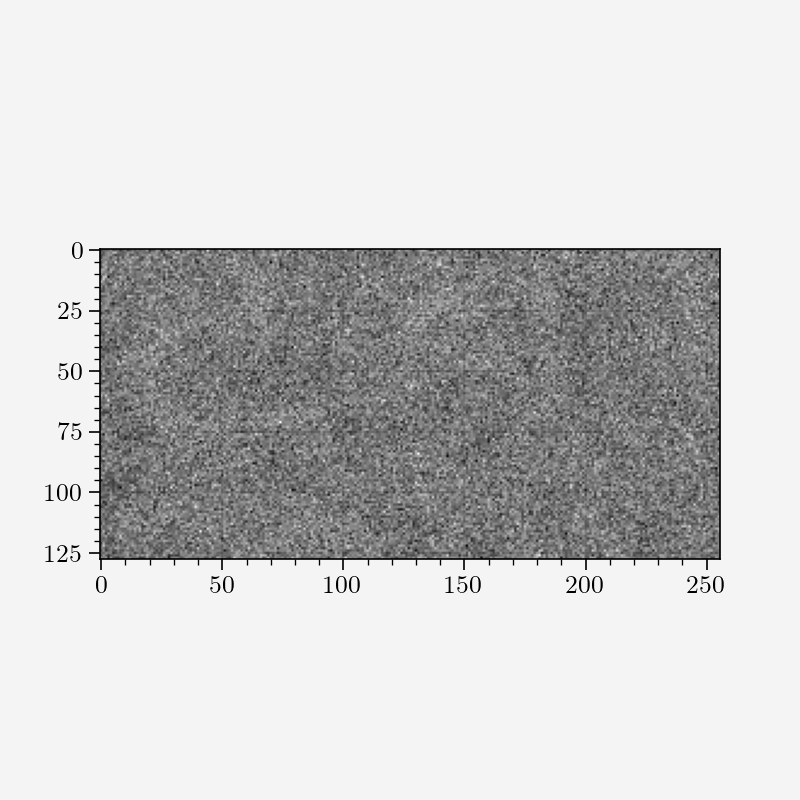

In [3]:
X1, X2, *_ = potentials.potential_features(nr, nc, ksize)
beta1, beta2, *_ = potentials.potential_features(nr, nc, ksize)
X = np.stack([X1, X2])
beta = np.stack([beta1, beta2])
Ytrue = np.einsum('ijk,ijk->jk', X, beta)
Y = Ytrue + 0.05 * np.random.normal(0, 1, (nr, nc))
plt.imshow(Y, cmap='gray')

In [151]:
class GMRFReg:
    def __init__(self, Y: np.ndarray, X: np.ndarray, lam: float = 1.0, sample_lam: bool = False):
        self.Y = Y
        self.X = X
        # precompute
        nr, nc = Y.shape
        self.nr = nr
        self.nc = nc
        self.n = nr * nc
        self.d = X.shape[0]
        self.sXX = np.square(X.flatten()).reshape(self.d, -1)
        # make graph laplacian
        self.G = nx.grid_2d_graph(nr, nc)
        ix1, ix2 = np.meshgrid(np.arange(nc), np.arange(nr))
        nodes = [(xi, yi) for xi, yi in zip(ix2.flatten(), ix1.flatten())]
        pair2node = {tuple(n): i for i, n in enumerate(nodes)}
        self.Laplacian = lam * nx.laplacian_matrix(self.G, nodes).transpose()
        # model params
        self.beta = np.random.normal(0, 1, (self.d, nr, nc))
        self.Mu = self.predict()
        self.prec = 1.0
        # opts
        self.sampling_ = True
        self.sample_lam = sample_lam
        self.lam = lam
        # precision params
        self.a = 1.0
        self.b = 1.0

    def predict(self, X=None):
        if X is None:
            X = self.X
        return np.einsum('ijk,ijk->jk', self.beta, X)

    def prec_step(self):
        sse = np.square(self.Mu - self.Y).sum()
        an = self.a + 0.5 * self.n
        bn = self.b + 0.5 * sse
        if self.sampling_:
            self.prec = np.random.gamma(an, 1.0 / bn)
        else:
            self.prec = (an - 1.0) / bn

    def lam_step(self):
        ssd1 = np.square(np.diff(self.beta, axis=1)).sum()
        ssd2 = np.square(np.diff(self.beta, axis=2)).sum()
        an = self.a + 0.5 * self.d * (self.nr * (self.nc - 1) + (self.nr - 1) * self.nc)
        bn = self.b + 0.5 * (ssd1 + ssd2)
        if self.sampling_:
            self.lam = np.random.gamma(an, 1.0 / bn)
        else:
            self.lam = (an - 1.0) / bn
    
    def beta_step_j(self, j: int):
        old_Mu_j = self.beta[j] * self.X[j]
        resid = (self.Y - self.Mu + old_Mu_j).flatten()
        # linear system components
        Q = self.Laplacian.copy()
        Q[np.diag_indices_from(Q)] += self.prec * self.sXX[j]
        mu_part = self.prec * self.X[j].flatten() * resid
        # cholesky
        f = cholesky(Q)
        # solution
        self.beta[j] = f.solve_A(mu_part).reshape(self.nr, self.nc)
        if self.sampling_:
            P = sparse.csc_matrix((np.ones(self.n), (f.P(), np.arange(self.n))))
            Z = (P @ f.solve_Lt(np.random.randn(self.n), False)).reshape(self.nr, self.nc)
            self.beta[j] += Z
        Mu_j = self.beta[j] * self.X[j]
        self.Mu += Mu_j - old_Mu_j

    def beta_step(self):
        Q = self.Laplacian.copy()
        for j in range(self.d):
            self.beta_step_j(j)

    def time_step(self, t: int):
        self.mcmc_step()
        self.prec_step()
        if self.sample_lam:
            self.lam_step()

    def mcmc_step(self):
        self.prec_step()
        if self.sample_lam:
            self.lam_step()
        self.beta_step()

    def opt_step(self):
        self.sampling_ = False
        self.mcmc_step()
        self.sampling_ = True

# test
model = GMRFReg(Y, X, lam=100.0, sample_lam=True)
# model.sampling_ = False

precs = []
lams = []

# for i in tqdm(range(100)):
#     model.opt_step()
#     precs.append(model.prec)

niter = 1000

post_betas = []
post_Mus = []
thinning = niter // 200
for i in tqdm(range(niter)):
    model.mcmc_step()
    # model.opt_step()
    precs.append(model.prec)
    lams.append(model.lam)
    if i > (niter // 2) and i % thinning == 0:
        post_betas.append(model.beta.copy())
        post_Mus.append(model.Mu.copy())

post_betas = np.stack(post_betas)
post_Mus = np.stack(post_Mus)
post_betas_m = post_betas.mean(0)
post_Mus_m = post_Mus.mean(0)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


<a list of 1 Line2D objects>

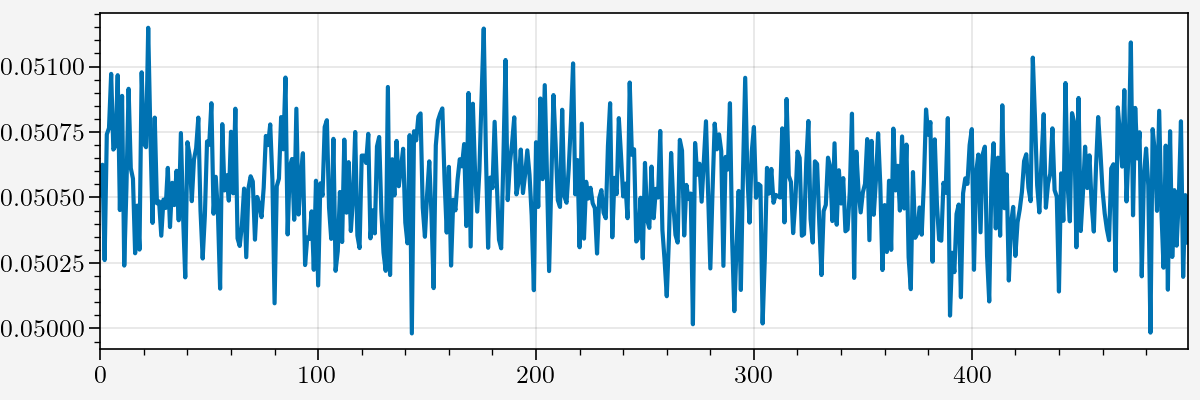

In [152]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
stdev = np.round(1.0 / np.sqrt(precs[(niter//2):]), 6)
plt.plot(stdev)

<a list of 1 Line2D objects>

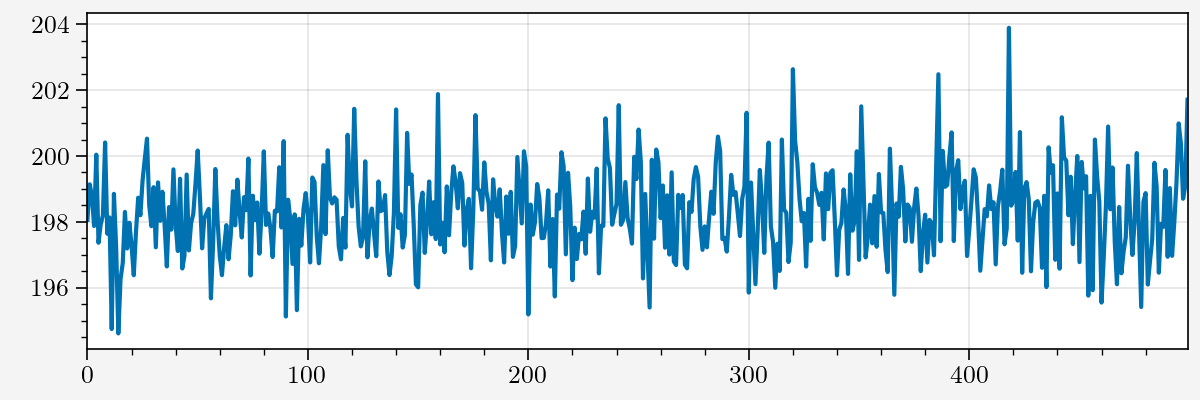

In [153]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
plt.plot(lams[(niter//2):])

<a list of 1 Line2D objects>

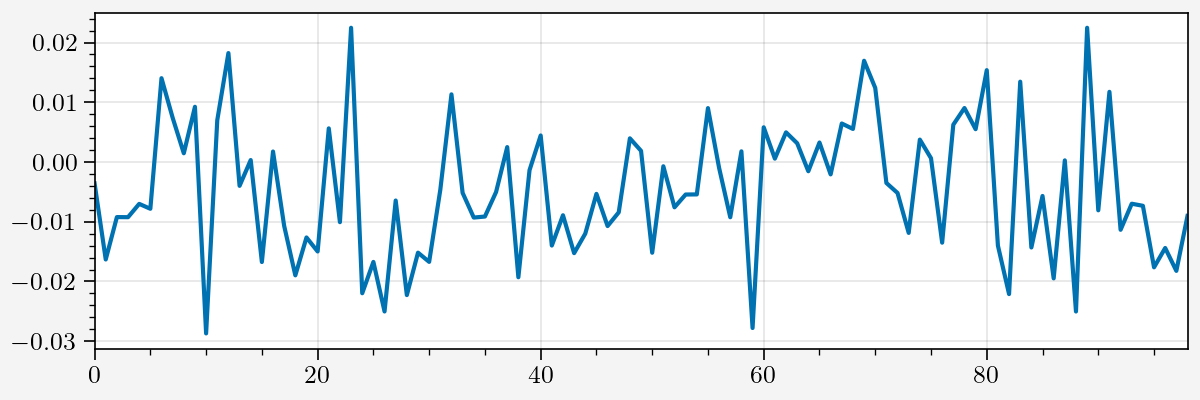

In [158]:
pplt.subplots(nrows=1, ncols=1, figsize=(6, 2))
plt.plot(post_Mus[:, 0, 0])

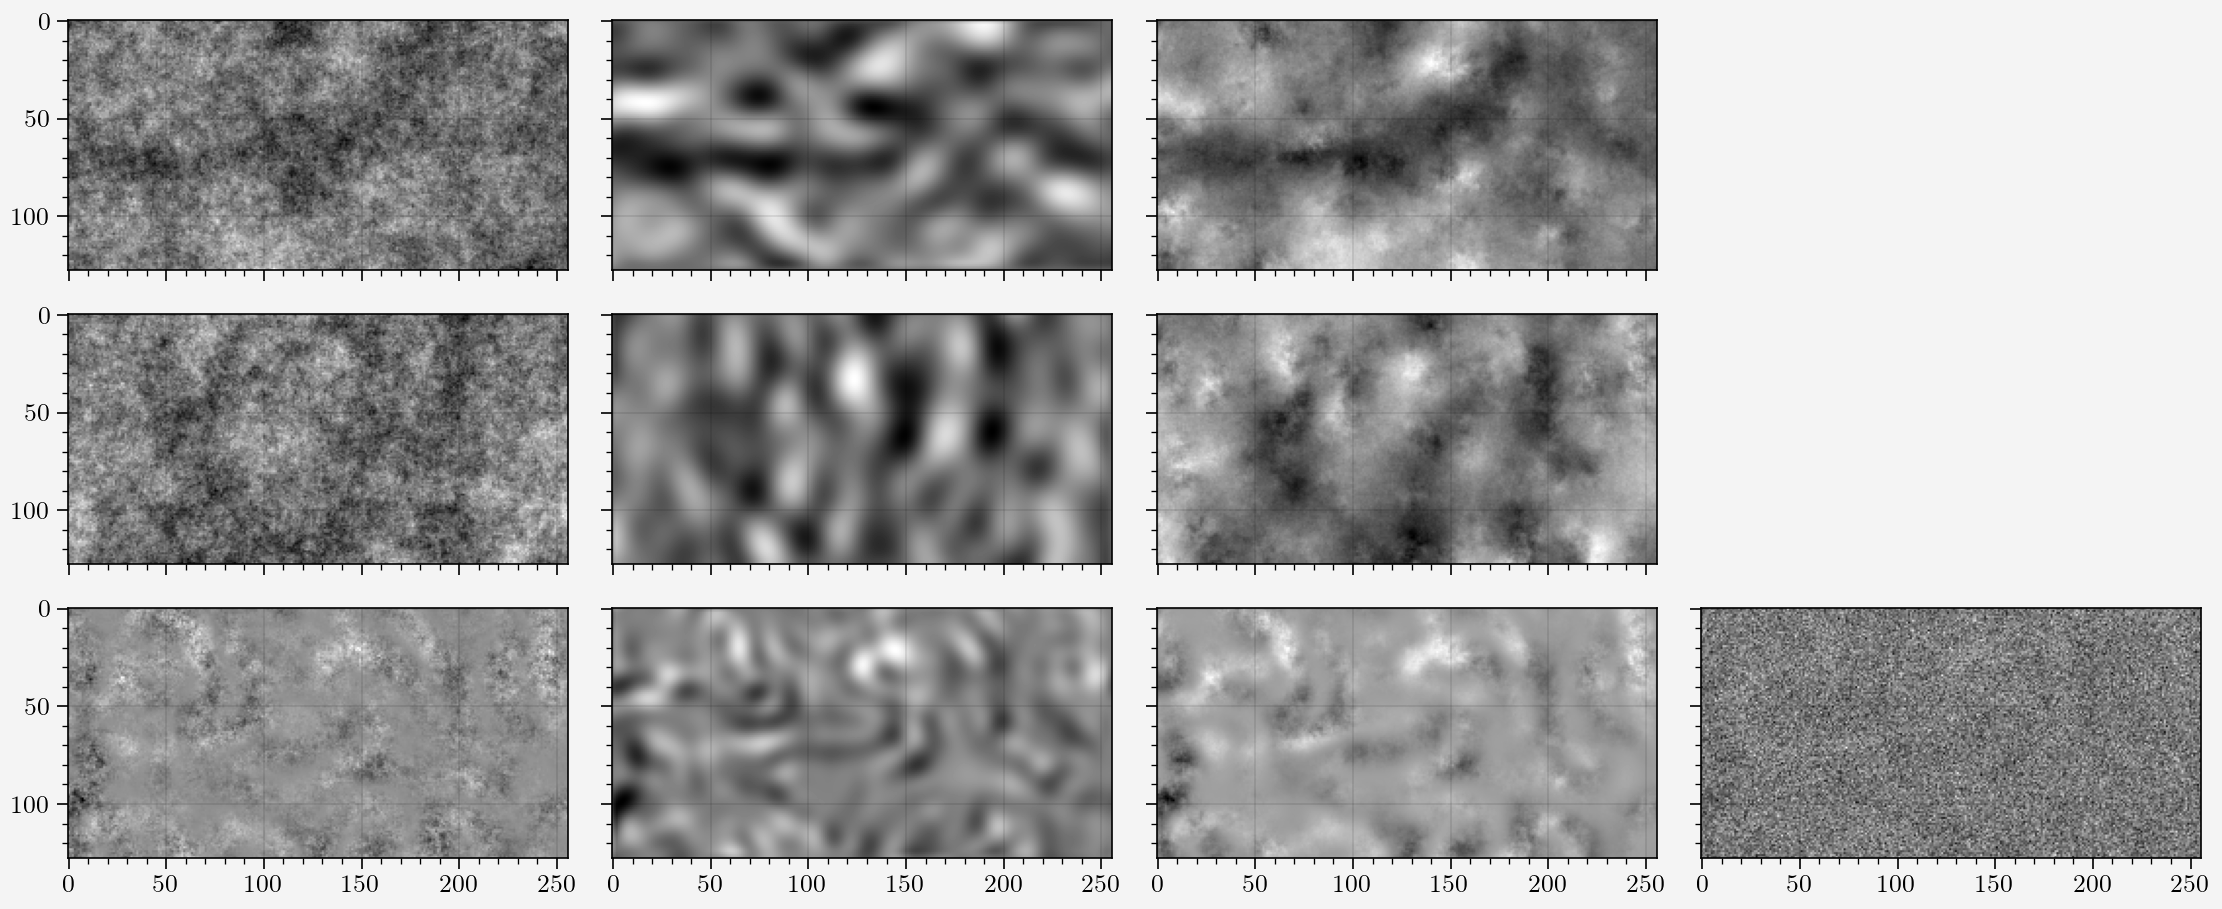

In [160]:
fig, ax = pplt.subplots([[1, 2, 7, 0], [3, 4, 8, 0], [5, 6, 9, 10]])

ax[0].imshow(model.beta[0], cmap='gray')
ax[1].imshow(beta[0], cmap='gray')
ax[2].imshow(model.beta[1], cmap='gray')
ax[3].imshow(beta[1], cmap='gray')
ax[4].imshow(model.Mu, cmap='gray')
ax[5].imshow(Ytrue, cmap='gray')
ax[6].imshow(post_betas_m[0], cmap='gray')
ax[7].imshow(post_betas_m[1], cmap='gray')
ax[8].imshow(post_Mus_m, cmap='gray')
ax[9].imshow(Y, cmap='gray')